In [1]:
import json

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets

from stellarpunk import util

# Loading and Preparing Data

In [2]:
df_base = pd.read_json("/tmp/stellarpunk.history.gz", lines=True)
df_base = df_base.join(pd.json_normalize(df_base["o"]).add_prefix("o."))

In [3]:
eids = pd.Series(df_base["eid"].unique())
eids

0     4c4f3f9f-d1a7-421e-90cb-57b79767a3f4
1     5b4b9d34-249b-4740-b794-7b8796954330
2     c7eea0ef-cfed-42af-bd5e-170b0d9cc8f9
3     e31e2147-edad-4ca9-b03c-b16b641d0670
4     a4da5c17-d684-4e0a-9eb9-5f802c5cebb0
5     65cdfaab-8d09-4c08-becb-347cc9d1a1f9
6     22afb833-e6ef-4b84-aa80-46864a9faa0d
7     043dea04-5427-4978-8625-dc09cb41c769
8     8d2d8c40-4fad-4b67-83d2-a48e89bea69f
9     35dcb19d-3b8d-49e7-a1d5-6e49265ba200
10    39fcc6db-1304-4fe1-ba88-6b679f05931d
11    2fba061c-7705-4235-89ff-8d008842d94f
12    bb450757-ff60-45ee-bbb2-5a6de4582ed0
13    8cfc85f8-be3f-4533-86be-7b2d65e1bfe0
14    23981c26-1efc-42e0-a13b-2553b44a6d3a
15    9efa58d9-11be-4459-9ff6-4fd5e777930c
16    79a10a3d-fb77-4061-8e53-802e0d3212e7
17    727c7940-51a3-47a9-a7d8-e2368f762b1d
18    cda36eb8-5436-4bb7-b8de-744f368431ed
19    923b26ed-7522-4059-9f17-da12fb09cf2b
20    026c218e-7f6b-465c-897c-426f5afc1385
21    f330961c-1f2f-4732-a1fd-69cc56466c2b
22    59eb7f2f-7c30-4b9e-8b54-b60e3f7fc01c
23    12aca

In [4]:
eids[pd.Series(df_base["eid"].unique()).str.startswith("0b30")]

31    0b303acf-233d-4820-88d9-ff1141ebb712
dtype: object

In [5]:
target_eid = df_base["eid"].unique()[30]
df_base = df_base[df_base["eid"] == target_eid].reset_index()
df_base["eid"].unique()

array(['a0d38d95-d59b-4579-9f6b-dea93640b079'], dtype=object)

In [6]:
loc = pd.DataFrame(np.vstack(df_base["loc"]), columns=["loc.x", "loc.y"])
v = pd.DataFrame(np.vstack(df_base["v"]), columns=["v.x", "v.y"])

empty_array = np.empty(len(df_base))
empty_array[:] = np.nan

if "o.t_loc" in df_base:
    o_tloc = pd.DataFrame(np.vstack(df_base["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_loc.x", "o.t_loc.y"])
    o_tv = pd.DataFrame(np.vstack(df_base["o.t_v"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_v.x", "o.t_v.y"])
else:
    o_tloc = pd.DataFrame({"o.t_loc": empty_array, "o.t_loc.x": empty_array, "o.t_loc.y": empty_array})
    o_tv = pd.DataFrame({"o.t_v": empty_array, "o.t_v.x": empty_array, "o.t_v.y": empty_array})
    
if "o.ct" in df_base:
    o_ctloc = pd.DataFrame(np.vstack(df_base["o.ct_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_loc.x", "o.ct_loc.y"])
    o_ctdv = pd.DataFrame(np.vstack(df_base["o.ct_dv"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_dv.x", "o.ct_dv.y"])
    o_ctv = pd.DataFrame(np.vstack(df_base["o.ct_v"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_v.x", "o.ct_v.y"])
    o_ctcloc = pd.DataFrame(np.vstack(df_base["o.ct_cloc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_cloc.x", "o.ct_cloc.y"])
else:
    o_ctloc = pd.DataFrame({"o.ct_loc": empty_array, "o.ct_loc.x": empty_array, "o.ct_loc.y": empty_array})
    o_ctdv = pd.DataFrame({"o.ct_dv": empty_array, "o.ct_dv.x": empty_array, "o.ct_dv.y": empty_array})
    o_ctv = pd.DataFrame({"o.ct_v": empty_array, "o.ct_v.x": empty_array, "o.ct_v.y": empty_array})
    o_ctcloc = pd.DataFrame({"o.ct_cloc": empty_array, "o.ct_cloc.x": empty_array, "o.ct_cloc.y": empty_array})
angle = pd.DataFrame(np.vstack(df_base.apply(lambda row: np.array(util.polar_to_cartesian(100, row["a"])), axis=1)), columns=["angle.x", "angle.y"])
df = pd.concat([df_base, loc, v, o_ctloc, o_ctcloc, o_ctdv, o_ctv, o_tloc, o_tv, angle], axis=1)

if "o.ct" not in df_base:
    df["o.ct"] = empty_array
    df["o.ct_ts"] = empty_array
    df["o.cac"] = empty_array
    df["o.cbdr"] = empty_array
    df["o.ct_ct"] = empty_array
    df["o.ct_cradius"] = empty_array
    
if "o.t_loc" not in df_base:
    df["o.cs"] = empty_array

In [7]:
df["speed"] = np.linalg.norm(df[["v.x", "v.y"]], axis=1)
df["o.ct_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.ct_cloc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)
df["o.t_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)
df["o.t_speed"] = np.linalg.norm(df[["o.t_v.x", "o.t_v.y"]], axis=1)
df["f_mag"] = df["f"].apply(lambda x:np.linalg.norm(x))

In [8]:
#df["o.ct_v.x"] = (df["o.ct_loc.x"].shift(1) - df["o.ct_loc.x"]) / (df["ts"].shift(1) - df["ts"])
#df["o.ct_v.y"] = (df["o.ct_loc.y"].shift(1) - df["o.ct_loc.y"]) / (df["ts"].shift(1) - df["ts"])

In [9]:
df

,index,eid,ts,loc,a,v,av,f,t,o,...,o.t_loc.y,o.t_v.x,o.t_v.y,angle.x,angle.y,speed,o.ct_dist,o.t_dist,o.t_speed,f_mag
0,30,a0d38d95-d59b-4579-9f6b-dea93640b079,2947.207783,"[-38076.28113937445, 111891.06094843622]",-16.513672,"[-635.0373359460685, 772.4814444079029]",0.0,"[0.0, 0.0]",0.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,153003.452993,-635.037336,772.481444,-69.260008,72.132179,1000.000000,NaN,53221.203360,1000.0,0.0
1,31,a0d38d95-d59b-4579-9f6b-dea93640b079,2947.224450,"[-38086.86509497355, 111903.93563917636]",-16.513672,"[-635.0373359460687, 772.4814444079029]",0.0,"[0.0, 0.0]",0.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,153003.452993,-635.037336,772.481444,-69.260008,72.132179,1000.000000,NaN,53204.536694,1000.0,0.0
2,32,a0d38d95-d59b-4579-9f6b-dea93640b079,2947.241117,"[-38097.44905057266, 111916.8103299165]",-16.513672,"[-635.0373359460685, 772.4814444079028]",0.0,"[0.0, 0.0]",0.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,153003.452993,-635.037336,772.481444,-69.260008,72.132179,1000.000000,NaN,53187.870027,1000.0,0.0
3,33,a0d38d95-d59b-4579-9f6b-dea93640b079,2947.257783,"[-38108.03300617176, 111929.68502065663]",-16.513672,"[-635.0373359460687, 772.4814444079029]",0.0,"[0.0, 0.0]",0.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,153003.452993,-635.037336,772.481444,-69.260008,72.132179,1000.000000,NaN,53171.203360,1000.0,0.0
4,34,a0d38d95-d59b-4579-9f6b-dea93640b079,2947.274450,"[-38118.616961770866, 111942.55971139677]",-16.513672,"[-635.0373359460687, 772.4814444079029]",0.0,"[0.0, 0.0]",0.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,153003.452993,-635.037336,772.481444,-69.260008,72.132179,1000.000000,NaN,53154.536694,1000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,3625,a0d38d95-d59b-4579-9f6b-dea93640b079,3007.124450,"[-71578.29399670796, 151453.84519235455]",-13.415556,"[330.33195724315664, -375.3409090732113]",0.0,"[330331.9572431569, -375340.90907321195]",0.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,-6155.581541,660.663914,-750.681818,66.059510,-75.074237,500.000000,NaN,209955.034109,1000.0,500000.0
3596,3626,a0d38d95-d59b-4579-9f6b-dea93640b079,3007.141117,"[-71572.78846408724, 151447.58951053667]",-13.415556,"[333.08472355351626, -378.46874998215475]",0.0,"[330331.95724315656, -375340.90907321224]",0.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,-6155.581541,660.663914,-750.681818,66.059510,-75.074237,504.166667,NaN,209946.700775,1000.0,500000.0
3597,3627,a0d38d95-d59b-4579-9f6b-dea93640b079,3007.157783,"[-71567.23705202801, 151441.28169803697]",-13.415556,"[335.8374898638759, -381.5965908910982]",0.0,"[330331.95724315656, -375340.90907321224]",0.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,-6155.581541,660.663914,-750.681818,66.059510,-75.074237,508.333333,NaN,209938.297998,1000.0,500000.0
3598,3628,a0d38d95-d59b-4579-9f6b-dea93640b079,3007.174450,"[-71561.63976053028, 151434.92175485546]",-13.415556,"[338.5902561742355, -384.7244318000416]",0.0,"[330331.9572431569, -375340.90907321195]",0.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,-6155.581541,660.663914,-750.681818,66.059510,-75.074237,512.500000,NaN,209929.825775,1000.0,500000.0


In [10]:
df.iloc[-1]["o"]

{'o': 'stellarpunk.orders.GoToLocation',
 'nnd': inf,
 't_loc': [67131.42070368413, -6155.581541393755],
 't_v': [660.6639144863138, -750.6818181464239],
 'cs': False}

# Basic Ship Vitals

## Position and Heading

In [11]:
def plot_location_chart(max_time):
    sample = df[df["ts"] <= max_time].iloc[::50]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"])#, scale=100)
    plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"])
    #center = (0,2500)
    #radius = 10000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

ipywidgets.interact(plot_location_chart, max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=3007.191116677348, continuous_update=False, description='max_time', ma…

<function __main__.plot_location_chart(max_time)>

In [12]:
df[["loc.x", "loc.y"]].describe()

,loc.x,loc.y
count,3600.000000,3600.000000
mean,-56716.864667,134372.125926
std,10439.208233,12442.023431
min,-71905.873188,111891.060948
25%,-66259.532065,123475.063942
50%,-57122.100837,135059.056714
75%,-47599.195190,146142.855506
max,-38076.281139,151826.058261


Text(0.5, 1.0, 'position')

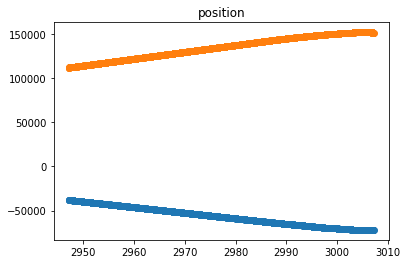

In [13]:
plt.scatter(df["ts"], df["loc.x"])
plt.scatter(df["ts"], df["loc.y"])
plt.title("position")

Text(0.5, 1.0, 'heading and angular velocity')

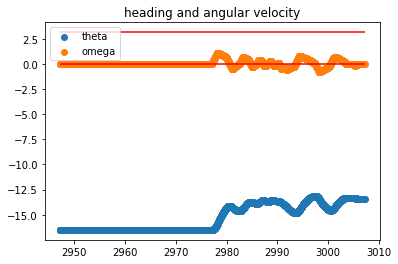

In [14]:
plt.scatter(df["ts"], df["a"], label="theta")
plt.scatter(df["ts"], df["av"], label="omega")
plt.hlines(np.pi, df["ts"].min(), df["ts"].max(), color="red")
plt.hlines(0, df["ts"].min(), df["ts"].max(), color="red")
plt.legend()
plt.title("heading and angular velocity")

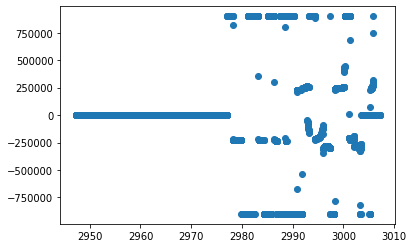

In [15]:
plt.scatter(df["ts"], df["t"])

## Velocity and Acceleration

Text(0.5, 1.0, 'velocity')

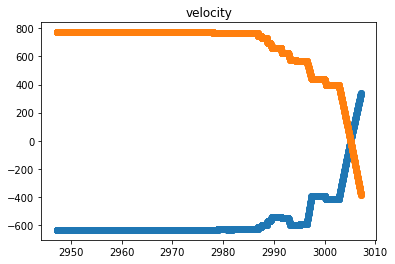

In [16]:
plt.scatter(df["ts"], df["v.x"])
plt.scatter(df["ts"], df["v.y"])
plt.title("velocity")

Text(0.5, 1.0, 'acceleration')

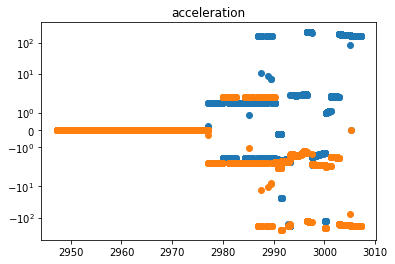

In [17]:
#plt.scatter(df["ts"], (df["v.x"] - df["v.x"].shift(-1)))#/(df["ts"]-df["ts"].shift(-1)))
plt.scatter(df["ts"], (df["v.x"].shift(1) - df["v.x"]) / (df["ts"].shift(1) - df["ts"]))
plt.scatter(df["ts"], (df["v.y"].shift(1) - df["v.y"]) / (df["ts"].shift(1) - df["ts"]))
plt.yscale("symlog")
plt.title("acceleration")

Text(0.5, 1.0, 'force')

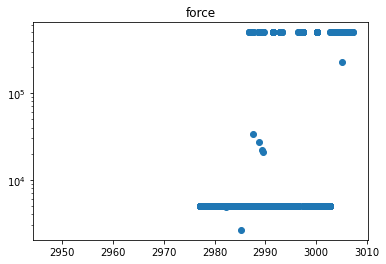

In [18]:
plt.scatter(df["ts"], df["f_mag"])
plt.yscale("log")
plt.title("force")

# Behavior Monitoring

In [19]:
[next((df.iloc[idx]["ts"] if idx is not None else None for idx, v in zip(df.index, (~df[c].isna() & df[c] == True)) if v), None) for c in ["o.ct", "o.cs", "o.cac", "o.cbdr"]]

[2990.257783343799, 3003.741116677304, None, 2990.7577833438054]

In [20]:
def plot_collision_info(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], (~(sample["o.ct"].isna())).astype(int), label="ct")
    plt.scatter(sample["ts"], sample["o.cs"].fillna(0).astype(int)+0.05, label="cs")
    plt.scatter(sample["ts"], sample["o.cac"].fillna(0).astype(int)+0.1, label="cac")
    plt.scatter(sample["ts"], sample["o.cbdr"].fillna(0).astype(int)+0.15, label="cbdr")
    plt.legend()
    plt.title("status flags")
    
    flag_cols = ["o.ct", "o.cs", "o.cac", "o.cbdr"]
    first_ts = [next((df.iloc[idx]["ts"] if idx is not None else None for idx, v in zip(df.index, (~df[c].isna() & df[c] == True)) if v), None) for c in flag_cols]
    for c, ts in zip(flag_cols, first_ts):
        print(f'first {c}: {ts}')

ipywidgets.interact(plot_collision_info, hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=59.983333…

<function __main__.plot_collision_info(hist_length, max_time)>

### Target Location

In [21]:
if np.any(~df["o.t_loc"].isna()):
    x = df.groupby(["o.t_loc.x", "o.t_loc.y"]).agg({"ts": ["count", "min", "max"], "o.t_dist": ["min","max"]})
else:
    x = "no location target"
x

ts                                 o.t_dist  \
                             count          min          max            min   
o.t_loc.x     o.t_loc.y                                                       
-71873.732337  153003.452993  3474  2947.207783  3005.091117    1177.854600   
 67131.420704 -6155.581541     125  3005.124450  3007.191117  209921.284109   

                                             
                                        max  
o.t_loc.x     o.t_loc.y                      
-71873.732337  153003.452993   53221.203360  
 67131.420704 -6155.581541    210450.867442

In [22]:
#sample = df[(df["ts"] < 124.4) & (df["ts"] > 120)]
def plot_target_distance(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.t_dist"])
    plt.hlines(1500, sample["ts"].min(), sample["ts"].max(), color="green")
    plt.hlines(1500*0.9, sample["ts"].min(), sample["ts"].max(), color="red")
    #plt.ylim(0,1500)
    plt.title("distance to target")
    print(sample["o.t_dist"].min(),sample[df["ts"] > sample["ts"].max()-1]["o.t_dist"].min())

ipywidgets.interact(
    plot_target_distance,
    hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=59.983333…

<function __main__.plot_target_distance(hist_length, max_time)>

In [23]:
def plot_desired_speed(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["speed"], label="actual speed")
    plt.scatter(sample["ts"], sample["o.t_speed"], label="desired speed")
    plt.legend()
    plt.title("speed and desired speed to target")
    plt.ylim(0)

ipywidgets.interact(
    plot_desired_speed,
    hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=59.983333…

<function __main__.plot_desired_speed(hist_length, max_time)>

Text(0.5, 1.0, 'desired speed delta')

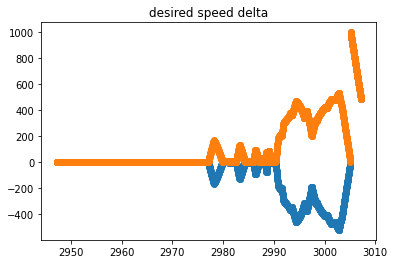

In [24]:
plt.scatter(df["ts"], df["o.t_speed"] - df["speed"])
plt.scatter(df["ts"], np.linalg.norm(np.array((df["o.t_v.x"] - df["v.x"], df["o.t_v.y"] - df["v.y"])), axis=0))
plt.title("desired speed delta")

## Collision Avoidance

In [25]:
if np.any(~df["o.ct"].isna()):
    x = df.groupby("o.ct").agg({"ts": ["count", "min", "max"], "o.ct_dist": ["min","max"]})
else:
    x = "no collision threats"
x

ts                            \
                                     count          min          max   
o.ct                                                                   
0b303acf-233d-4820-88d9-ff1141ebb712   406  2990.257783  3001.191117   

                                        o.ct_dist                
                                              min           max  
o.ct                                                             
0b303acf-233d-4820-88d9-ff1141ebb712  1473.306235  10018.216435

In [26]:
def plot_collision_distance(hist_length, max_time):
    sample = df[(df["ts"] >= max_time-hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.ct_dist"])
    plt.hlines(60+500+500, sample["ts"].min(), sample["ts"].max(), color="green")
    plt.hlines(60+500, sample["ts"].min(), sample["ts"].max(), color="orange")
    plt.hlines(330, sample["ts"].min(), sample["ts"].max(), color="red")
    plt.hlines(60, sample["ts"].min(), sample["ts"].max(), color="red")
    plt.ylim(0)
    plt.title("distance to collision threat")
    print(sample["o.ct_dist"].min())

ipywidgets.interact(
    plot_collision_distance,
    hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False)
)

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=59.983333…

<function __main__.plot_collision_distance(hist_length, max_time)>

(2947.207783343251, 3007.191116677348)

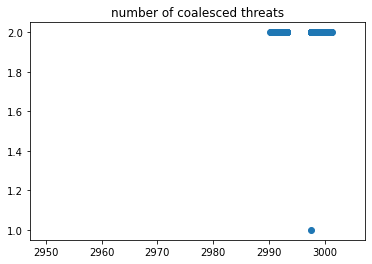

In [27]:
plt.scatter(df["ts"], df["o.ct_ct"])
plt.title("number of coalesced threats")
plt.xlim(df["ts"].min(), df["ts"].max())

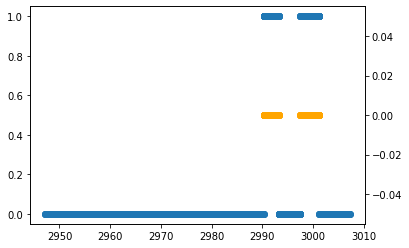

In [28]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.scatter(df["ts"], 1-df["o.ct"].isna().astype(int))
ax2.scatter(df["ts"], df["ts"] - df["o.ct_ts"], color="orange")

#ax2.set_ylim(0,(df["ts"] - df["o.ct_ts"]).max()*1.2)

In [29]:
def plot_collision_dv(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.ct_dv.x"])
    plt.scatter(sample["ts"], sample["o.ct_dv.y"])
    plt.title("collision avoidance velocity")

ipywidgets.interact(
    plot_collision_dv,
    hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=59.983333…

<function __main__.plot_collision_dv(hist_length, max_time)>

# History Visualization

## Position and Velocity

In [30]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max(), sampling_interval=50, show_tloc=True):
    plt.figure(figsize=(10, 10))
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)].iloc[::sampling_interval]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["v.x"], sample["v.y"], label="v")
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"], ctdv_df["o.ct_dv.y"], label="ctdv", color="orange")
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], label="tv", color="purple")
    
    plt.quiver(sample["o.ct_loc.x"], sample["o.ct_loc.y"], sample["o.ct_v.x"], sample["o.ct_v.y"])
    cmap = plt.get_cmap('viridis')
    for x, c in zip(df["o.ct"].unique(), cmap(np.linspace(0, 1, len(df["o.ct"].unique())))):
        if not isinstance(x, str):
            continue
        ct = sample[sample["o.ct"] == x]
        if len(ct) == 0:
            continue
        plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
        
        t_next = 10
        x, y = ct.iloc[-1]["o.ct_loc.x"], ct.iloc[-1]["o.ct_loc.y"]
        x_next, y_next = ct.iloc[-1]["o.ct_loc.x"]+ct.iloc[-1]["o.ct_v.x"]*t_next, ct.iloc[-1]["o.ct_loc.y"]+ct.iloc[-1]["o.ct_v.y"]*t_next
        if x_next != x or y_next != y:
            plt.axline((x,y),(x_next,y_next), marker = 'x', color=c, dashes=[2,2])
           
    cloc_df = sample[~(sample["o.ct_cloc"].isna())]
    if len(cloc_df) > 0:
        cloc_x = cloc_df.iloc[-1]["o.ct_cloc.x"]
        cloc_y = cloc_df.iloc[-1]["o.ct_cloc.y"]
        cradius = cloc_df.iloc[-1]["o.ct_cradius"]
        threat_radius = plt.Circle((cloc_x, cloc_y), cradius, color="red", fill=False)
        margin = plt.Circle((cloc_x, cloc_y), cradius+30+500, color="orange", fill=False)
        margin = plt.Circle((cloc_x, cloc_y), cradius+30+500*2, color="green", fill=False)
        plt.gca().add_patch(threat_radius)
        plt.gca().add_patch(margin)
    
    if show_tloc:
        plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc")
        for (tloc_x, tloc_y) in sample.groupby(["o.t_loc.x", "o.t_loc.y"])["o.t_loc"].min():
            arrival_dist = plt.Circle((tloc_x, tloc_y), 1500, color="green", fill=False)
            min_dist = plt.Circle((tloc_x, tloc_y), 1500*0.9, color="red", fill=False)
            plt.gca().add_patch(arrival_dist)
            plt.gca().add_patch(min_dist)
            
    t_next = 10
    x, y = sample.iloc[-1]["loc.x"], sample.iloc[-1]["loc.y"]
    x_next, y_next = sample.iloc[-1]["loc.x"]+sample.iloc[-1]["v.x"]*t_next, sample.iloc[-1]["loc.y"]+sample.iloc[-1]["v.y"]*t_next
    if x_next != x or y_next != y:
        plt.axline((x,y),(x_next,y_next),marker = 'o')
    
    plt.axis('equal')
    #center = (-33555, -5000)
    #radius = 15000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

    plt.legend()
    plt.show()
    
ipywidgets.interact(
    plot_collision_chart,
    hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(step=1/60, value=df["ts"].max()+1/60, min=df["ts"].min(), max=df["ts"].max()+1/60, continuous_update=False),
    sampling_interval=ipywidgets.IntSlider(value=20, min=1, max=100, continuous_update=False),
    show_tloc=ipywidgets.Checkbox(value=True),
)

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=59.983333…

<function __main__.plot_collision_chart(hist_length=3007.191116677348, max_time=3007.191116677348, sampling_interval=50, show_tloc=True)>

## Position and Heading

In [31]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max()):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)].iloc[::10]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"], label="ship")
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"], ctdv_df["o.ct_dv.y"], label="ctdv", color="orange")
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], label="tv", color="purple")
    cmap = plt.get_cmap('viridis')
    #for x, c in zip(df["o.ct"].unique(), cmap(np.linspace(0, 1, len(sample["o.ct"].unique())))):
    #    print(x)
    #    if not isinstance(x, str):
    #        continue
    #    ct = sample[sample["o.ct"] == x]
    #    plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
    #plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc")
    #plt.axis('square')
    #center = (-33555, -5000)
    #radius = 15000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)
    
    plt.legend()
    plt.axis('equal')
    plt.show()
    
ipywidgets.interact(plot_collision_chart, hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=59.983333…

<function __main__.plot_collision_chart(hist_length=3007.191116677348, max_time=3007.191116677348)>

# 